In [1]:
import sys
sys.path.append('/mydata/universal-robust-attack/')
import os.path as osp
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torchvision.datasets as tvdatasets
from torchvision.transforms import transforms

import modelzoo.zoo as zoo
import datasets
import config as cfg
from model_utils import*
from mymodelzoo import*
from transforms import*
from utils import*
from adversary import*
from AdamOptimizer import*

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

GeForce GTX 1080 Ti


In [2]:
SEED = 888

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
params = {"model_name":"resnet50",
          "dataset_name":"ImageNet1k",
          "num_classes":1000,
          "pretrained":"imagenet"}

In [4]:
model_name = params["model_name"]
dataset_name = params["dataset_name"]
modelfamily = datasets.dataset_to_modelfamily[dataset_name]
num_classes = params["num_classes"]
pretrained = params["pretrained"]
model = zoo.get_net(model_name, modelfamily, num_classes=num_classes, pretrained=pretrained)
model = model.to(device)
normalize = transforms.Normalize(mean=cfg.IMAGENET_MEAN,
                                 std=cfg.IMAGENET_STD)
MEAN = torch.Tensor(cfg.IMAGENET_MEAN).reshape([1, 3, 1, 1])
STD = torch.Tensor(cfg.IMAGENET_STD).reshape([1, 3, 1, 1])

In [5]:
idx2name = {403:"aircraft_carrier",
            407:"ambulance",
            466:"bullet_train",
            764:"rifle",
            779:"school_bus"}

candidates = [403, 407, 466, 764, 779]

In [6]:
T = [get_random_gaussian_pt(device=device, max_sigma=0.1, mean=MEAN, std=STD),
     get_random_rotate_kornia(max_deg=22.5),
     get_random_contrast_pt(device=device, min_alpha=0.9, max_alpha=1.4, mean=MEAN, std=STD),
     get_random_brightness_pt(device=device, min_beta=-0.05, max_beta=0.05, mean=MEAN, std=STD)]

random_transform = RandomTransform(T)
N = len(T)

# Experiment parameters
shape = (1, 3, 224, 224)
epochs = 1
step_size = 2e-3
eps = 0.25
loss_max = 3.
log_interval = 1
demo_steps = 1
verbose = False
optimizer = AdamOptimizer(shape, step_size, device)
criterion = get_clipped_loss(nn.CrossEntropyLoss(), float("-inf"), loss_max)
out_dir = "./results/"

[Test]  Epoch: 0.0	Loss: 0.099407	Acc: 98.4% (252/256)


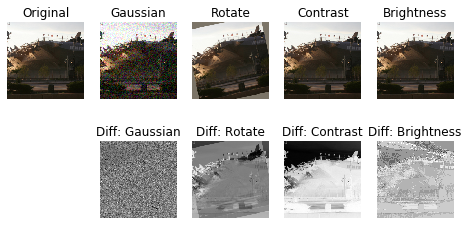

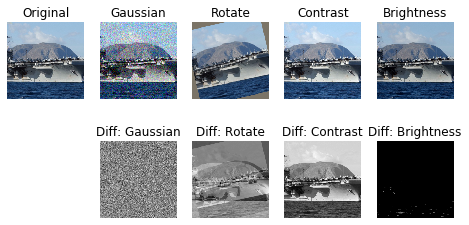

Start crafting perturbation for class [aircraft_carrier]...
Finished crafting (2.4 mins used)
Success rate: 0.90625
Create new checkpoint.
[Test]  Epoch: 0.0	Loss: 0.479087	Acc: 83.5% (228/273)


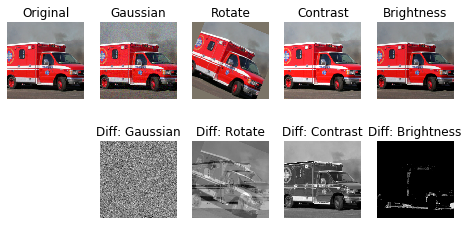

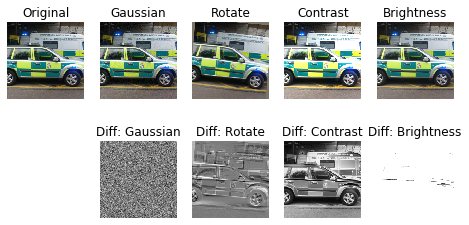

Start crafting perturbation for class [ambulance]...
Finished crafting (2.4 mins used)
Success rate: 0.6190476190476191
Create new checkpoint.
[Test]  Epoch: 0.0	Loss: 0.067209	Acc: 98.6% (277/281)


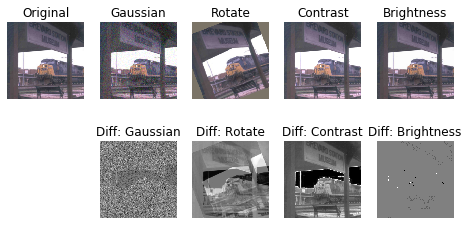

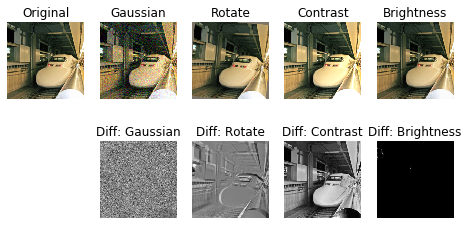

Start crafting perturbation for class [bullet_train]...
Finished crafting (2.4 mins used)
Success rate: 0.9608540925266904
Create new checkpoint.
[Test]  Epoch: 0.0	Loss: 0.793352	Acc: 71.1% (170/239)


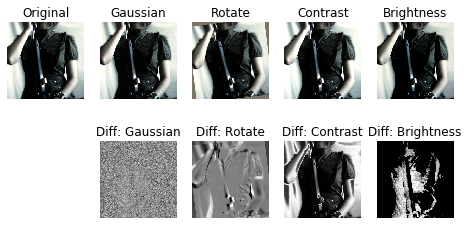

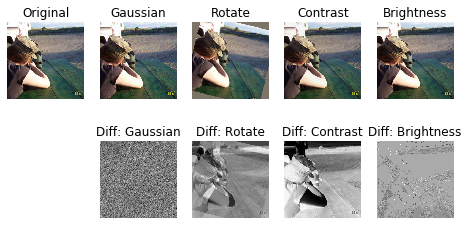

Start crafting perturbation for class [rifle]...
Finished crafting (2.5 mins used)
Success rate: 0.8075313807531381
Create new checkpoint.
[Test]  Epoch: 0.0	Loss: 0.089030	Acc: 97.2% (241/248)


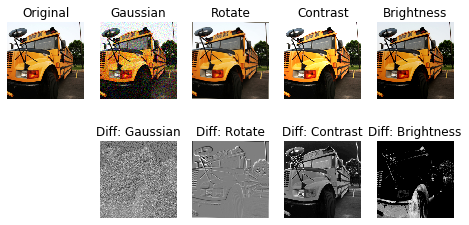

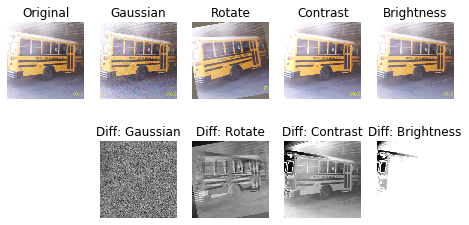

Start crafting perturbation for class [school_bus]...
Finished crafting (2.5 mins used)
Success rate: 0.782258064516129
Create new checkpoint.


In [9]:
N = len(T)
for target_class in candidates:
    classname = idx2name[target_class]
    trainset = TargetClassSet(f"./data/{classname}_train.pt", transform=normalize)
    trainloader = DataLoader(trainset, batch_size=1, num_workers=10)
    testset = TargetClassSet(f"./data/{classname}_val.pt", transform=normalize)
    testloader = DataLoader(testset, batch_size=1, num_workers=10)
    save_path = osp.join(out_dir, f"unipert_{classname}_eps{eps}.ckp")
    # ----------------- Validate on clean images
    _, clean_acc = test_step(model, testloader, criterion, device)
    # ----------------- Inspect transformed images
    for i, (image, label) in enumerate(trainloader, 1):
        _image = (image*STD + MEAN)[0].numpy().transpose([1, 2, 0])
        image = image.to(device)
        xt_list, label_list = [], ["Original", "Gaussian", "Rotate", "Contrast", "Brightness"]
        fig = plt.figure(figsize=(8, 4))
        ax = plt.subplot(2, N+1, 1)
        ax.set_title(label_list[0])
        plt.imshow(_image)
        plt.axis("off")
        for t in T:
            xt_list.append(t(image))
        for c in range(2, N+2):
            ax = plt.subplot(2, N+1, c)
            ax.set_title(label_list[c-1])
            x_t = xt_list[c-2].cpu()*STD + MEAN
            x_t = x_t[0].numpy().transpose([1, 2, 0])
            x_t = np.clip(x_t, 0., 1.)
            plt.imshow(x_t)
            plt.axis("off")
            ax = plt.subplot(2, N+1, c+N+1)
            ax.set_title(f"Diff: {label_list[c-1]}")
            plt.imshow((x_t - _image).sum(axis=-1)/3, cmap="gray")
            plt.axis("off")
        plt.show()
        print("=======================================================")
        if i == demo_steps:
            break

#     ----------------- Crafting
    print(f"Start crafting perturbation for class [{classname}]...")
    tic = time.time()
    uni_pert = uni_eot_craft(model, T, trainloader,
                             epochs, step_size, eps, device, shape=shape, optimizer=optimizer,
                             criterion=criterion, verbose=verbose, log_interval=log_interval)
    tac = time.time()
    print(f"Finished crafting ({(tac-tic)/60:.1f} mins used)")
    succ_rate = uni_adv_eval(model, uni_pert, random_transform, 
                             testloader, device, verbose=verbose, log_interval=100)

    
    ckp = {"uni_pert": uni_pert.cpu(),
           "victim_model": model_name,
           "clean_acc": clean_acc,
           "succ_rate": succ_rate,
           "eps": eps,
           "epochs": epochs,
           "step_size":step_size,
           "loss_max": loss_max}
    
    if osp.isfile(save_path):
        prev_ckp = torch.load(save_path)
        prev_succ_rate = prev_ckp["succ_rate"]
        if succ_rate >= prev_succ_rate:
            print("Replace the previous checkpoint.")
            torch.save(ckp, save_path)
            print(f"Saved the pertubation to {save_path}")
        else:
            print("Not better than the previous one, so ignore it.")
    else:
        print("Create new checkpoint.")
        torch.save(ckp, save_path)
    print("=======================================================")